# 1. Performance Metrics 

- Average finish times by age group 

In [16]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def time_to_seconds(value):
    if value is None:
        return np.nan
    text = str(value).strip()
    if text == "":
        return np.nan
    parts = text.split(":")
    if len(parts) == 2:
        hours = 0
        minutes, seconds = parts
    elif len(parts) == 3:
        hours, minutes, seconds = parts
    else:
        return np.nan
    try:
        return int(hours) * 3600 + int(minutes) * 60 + int(seconds)
    except ValueError:
        return np.nan


def seconds_to_hms(seconds):
    if pd.isna(seconds):
        return None
    seconds = int(seconds)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"


def map_age_group(code):
    if not code or code == "SIN_CATEGORIA":
        return "SIN_CATEGORIA"
    code = str(code).upper()
    if code.startswith("JV1"):
        return "Joven 11-15"
    if code.startswith("JV2"):
        return "Joven 16-19"
    if code.startswith("SN"):
        return "Senior 20-34"
    if code.startswith("VTA"):
        return "Veteranos A 35-44"
    if code.startswith("VTB"):
        return "Veteranos B 45-54"
    if code.startswith("VTC"):
        return "Veteranos C 55-64"
    if code.startswith("VTD"):
        return "Veteranos D 65+"
    return "OTRA"


candidate_paths = [
    Path("data/salidas.json"),
    Path("..") / "data" / "salidas.json",
    Path("../data/salidas.json"),
]
data_path = next((p for p in candidate_paths if p.exists()), None)
if data_path is None:
    raise FileNotFoundError("No se encontro data/salidas.json. Ejecuta el exportador primero.")


with data_path.open("r", encoding="utf-8") as file_handle:
    records = json.load(file_handle)


df = pd.DataFrame(records)


if "categoria" not in df.columns and "categoría" in df.columns:
    df["categoria"] = df["categoría"]


if "tiempo" not in df.columns:
    df["tiempo"] = None
if "sexo" not in df.columns:
    df["sexo"] = None
if "carrera" not in df.columns:
    df["carrera"] = None


df["year"] = pd.to_numeric(df["carrera"], errors="coerce")
df["time_seconds"] = df["tiempo"].apply(time_to_seconds)
df["gender"] = df["sexo"].astype(str).str.upper().str[0].map({"M": "M", "F": "F"})
df["categoria"] = df.get("categoria", pd.Series(dtype=str)).fillna("SIN_CATEGORIA")
df["categoria"] = (
    df["categoria"]
    .astype(str)
    .str.strip()
    .str.replace(r"[-\s]*\d+$", "", regex=True)
 )
df["age_group"] = df["categoria"].apply(map_age_group)


df_valid = df.dropna(subset=["year", "time_seconds"]).copy()
df_valid["year"] = df_valid["year"].astype(int)
df_valid_age = df_valid[~df_valid["age_group"].isin(["OTRA", "SIN_CATEGORIA"])].copy()


avg_by_age = (
    df_valid_age.groupby("age_group")
    .agg(participants=("time_seconds", "count"), avg_seconds=("time_seconds", "mean"))
    .reset_index()
    .sort_values("avg_seconds")
)
avg_by_age["avg_time"] = avg_by_age["avg_seconds"].apply(seconds_to_hms)


avg_by_age.head(50)

,age_group,participants,avg_seconds,avg_time
3,Veteranos A 35-44,9438,2594.385463,00:43:14
1,Joven 16-19,1341,2624.843400,00:43:44
4,Veteranos B 45-54,9367,2674.469627,00:44:34
2,Senior 20-34,8412,2692.361864,00:44:52
5,Veteranos C 55-64,3400,2778.351176,00:46:18
0,Joven 11-15,2148,2792.562384,00:46:32
6,Veteranos D 65+,736,2946.781250,00:49:06


- Average finish times by gender 

In [8]:
avg_by_gender = (
    df_valid.groupby("gender")
    .agg(participants=("time_seconds", "count"), avg_seconds=("time_seconds", "mean"))
    .reset_index()
    .sort_values("avg_seconds")
)
avg_by_gender["avg_time"] = avg_by_gender["avg_seconds"].apply(seconds_to_hms)


avg_by_gender

,gender,participants,avg_seconds,avg_time
1,M,26453,2444.773107,00:40:44
0,F,13394,2982.888980,00:49:42


# 2. Trend Analysis 

- Participation evolution over the years 

,year,participants
0,2010,460
1,2011,895
2,2012,1119
3,2014,2200
4,2015,2697
5,2016,3119
6,2017,3341
7,2018,3801
8,2019,4064
9,2021,2610


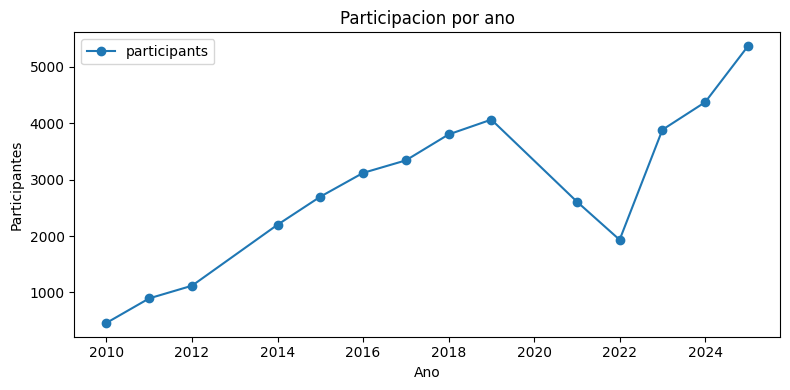

In [17]:
participants_by_year = (
    df_valid.groupby("year")
    .size()
    .reset_index(name="participants")
    .sort_values("year")
)


display(participants_by_year)


ax = participants_by_year.plot(
    x="year", y="participants", kind="line", marker="o", figsize=(8, 4)
 )
ax.set_title("Participacion por ano")
ax.set_xlabel("Ano")
ax.set_ylabel("Participantes")
plt.tight_layout()
plt.show()

- Male/female participation trends 

gender,F,M
year,,
2010,0.0,460.0
2011,0.0,895.0
2012,0.0,1119.0
2014,615.0,1585.0
2015,851.0,1846.0
2016,1006.0,2113.0
2017,1131.0,2210.0
2018,1322.0,2479.0
2019,1448.0,2616.0


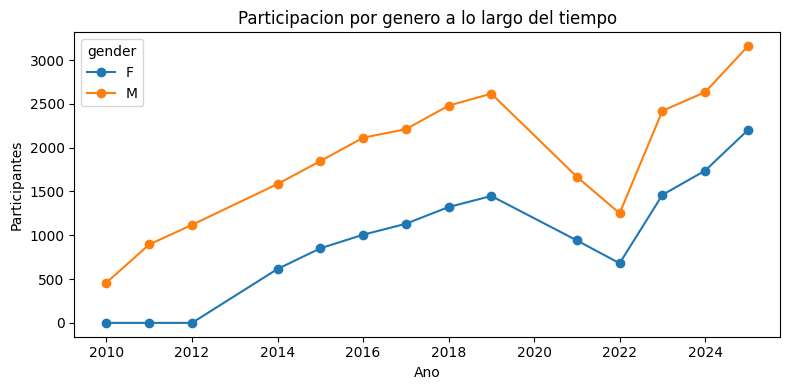

In [18]:
gender_by_year = (
    df_valid.groupby(["year", "gender"])
    .size()
    .reset_index(name="participants")
)


gender_pivot = (
    gender_by_year.pivot(index="year", columns="gender", values="participants")
    .fillna(0)
    .sort_index()
)


display(gender_pivot)


ax = gender_pivot.plot(kind="line", marker="o", figsize=(8, 4))
ax.set_title("Participacion por genero a lo largo del tiempo")
ax.set_xlabel("Ano")
ax.set_ylabel("Participantes")
plt.tight_layout()
plt.show()

- Evolution of mean and median times 

,year,mean_seconds,median_seconds,mean_time,median_time
0,2010,2175.604348,2133.5,00:36:15,00:35:33
1,2011,2283.334078,2219.0,00:38:03,00:36:59
2,2012,2385.015192,2363.0,00:39:45,00:39:23
3,2014,2178.928636,2144.0,00:36:18,00:35:44
4,2015,2578.058213,2574.0,00:42:58,00:42:54
5,2016,2147.951908,2155.0,00:35:47,00:35:55
6,2017,2438.208919,2434.0,00:40:38,00:40:34
7,2018,2483.670350,2486.0,00:41:23,00:41:26
8,2019,2759.439222,2753.0,00:45:59,00:45:53
9,2021,2562.664368,2505.0,00:42:42,00:41:45


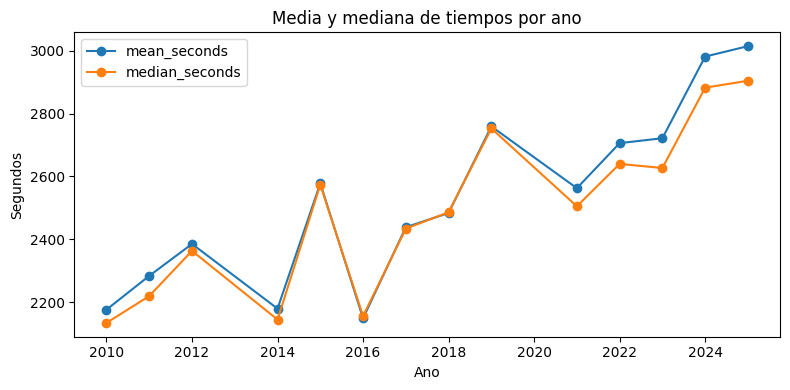

In [19]:
time_stats_by_year = (
    df_valid.groupby("year")
    .agg(mean_seconds=("time_seconds", "mean"), median_seconds=("time_seconds", "median"))
    .reset_index()
    .sort_values("year")
)
time_stats_by_year["mean_time"] = time_stats_by_year["mean_seconds"].apply(seconds_to_hms)
time_stats_by_year["median_time"] = time_stats_by_year["median_seconds"].apply(seconds_to_hms)


display(time_stats_by_year)


ax = time_stats_by_year.plot(
    x="year", y=["mean_seconds", "median_seconds"], kind="line", marker="o", figsize=(8, 4)
)
ax.set_title("Media y mediana de tiempos por ano")
ax.set_xlabel("Ano")
ax.set_ylabel("Segundos")
plt.tight_layout()
plt.show()

- Minimum and maximum times over the years 

,year,min_seconds,max_seconds,min_time,max_time
0,2010,1430,3307,00:23:50,00:55:07
1,2011,1451,3496,00:24:11,00:58:16
2,2012,1469,4183,00:24:29,01:09:43
3,2014,1255,3850,00:20:55,01:04:10
4,2015,1459,3954,00:24:19,01:05:54
5,2016,1083,3508,00:18:03,00:58:28
6,2017,1262,3930,00:21:02,01:05:30
7,2018,1254,4693,00:20:54,01:18:13
8,2019,1311,5112,00:21:51,01:25:12
9,2021,1302,4991,00:21:42,01:23:11


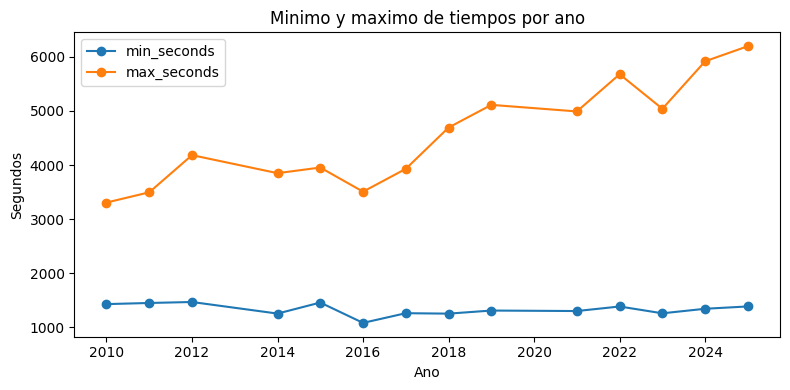

In [20]:
extremes_by_year = (
    df_valid.groupby("year")
    .agg(min_seconds=("time_seconds", "min"), max_seconds=("time_seconds", "max"))
    .reset_index()
    .sort_values("year")
)
extremes_by_year["min_time"] = extremes_by_year["min_seconds"].apply(seconds_to_hms)
extremes_by_year["max_time"] = extremes_by_year["max_seconds"].apply(seconds_to_hms)


display(extremes_by_year)


ax = extremes_by_year.plot(
    x="year", y=["min_seconds", "max_seconds"], kind="line", marker="o", figsize=(8, 4)
)
ax.set_title("Minimo y maximo de tiempos por ano")
ax.set_xlabel("Ano")
ax.set_ylabel("Segundos")
plt.tight_layout()
plt.show()

# 3. Top Performers 

- Identify top performers by average time across all races they participated in 

In [21]:
runner_perf = (
    df_valid.groupby(["nombre", "apellido", "gender"])
    .agg(races=("year", "count"), avg_seconds=("time_seconds", "mean"))
    .reset_index()
)


runner_perf = runner_perf[runner_perf["races"] >= 2]
runner_perf = runner_perf.sort_values("avg_seconds")
runner_perf["avg_time"] = runner_perf["avg_seconds"].apply(seconds_to_hms)


runner_perf.head(20)

,nombre,apellido,gender,races,avg_seconds,avg_time
13341,LUIS,PÉREZ VARELA,M,5,1301.600000,00:21:41
2738,ANXO,CASTRO VARELA,M,2,1302.000000,00:21:42
577,ALBERTO,CASTIÑEIRA FIGUEROA,M,4,1306.750000,00:21:46
694,ALBERTO,MORIS VIEITES,M,2,1334.000000,00:22:14
17,ABDELAZIZ,FATIHI CHHIMA,M,3,1343.666667,00:22:23
1493,ALVARO,PRESEDO FRAGUÍO,M,4,1344.250000,00:22:24
5686,DIEGO,CRESPO NAYA,M,3,1347.000000,00:22:27
14258,MARCOS ANTONIO,SEIJO BUJÍA,M,2,1359.000000,00:22:39
6991,FERNANDO,DÍEZ GOMEZ,M,4,1362.000000,00:22:42
18733,RAMON,SERANTES GOMEZ,M,2,1362.000000,00:22:42


# 4. Informe
Resumen de hallazgos clave basado en los resultados calculados en este notebook.

In [24]:
from IPython.display import Markdown, display


total_results = len(df_valid)
year_min = int(df_valid["year"].min())
year_max = int(df_valid["year"].max())


top_age = avg_by_age.sort_values("avg_seconds").head(1)
fastest_age_group = top_age.iloc[0]["age_group"] if not top_age.empty else "N/D"
fastest_age_time = top_age.iloc[0]["avg_time"] if not top_age.empty else "N/D"


top_gender = avg_by_gender.sort_values("avg_seconds").head(1)
fastest_gender = top_gender.iloc[0]["gender"] if not top_gender.empty else "N/D"
fastest_gender_time = top_gender.iloc[0]["avg_time"] if not top_gender.empty else "N/D"


max_participation_row = participants_by_year.loc[participants_by_year["participants"].idxmax()]
max_participation_year = int(max_participation_row["year"])
max_participation = int(max_participation_row["participants"])


latest_year = int(participants_by_year["year"].max())
latest_mean = time_stats_by_year.loc[time_stats_by_year["year"] == latest_year, "mean_time"].iloc[0]
latest_median = time_stats_by_year.loc[time_stats_by_year["year"] == latest_year, "median_time"].iloc[0]


global_min_time = seconds_to_hms(extremes_by_year["min_seconds"].min())
global_max_time = seconds_to_hms(extremes_by_year["max_seconds"].max())
global_range_seconds = int(extremes_by_year["max_seconds"].max() - extremes_by_year["min_seconds"].min())
global_range_time = seconds_to_hms(global_range_seconds)


top_performers = runner_perf.head(5)
top_names = ", ".join(
    f"{row['nombre']} {row['apellido']} ({row['avg_time']})"
    for _, row in top_performers.iterrows()
 )


time_stats_sorted = time_stats_by_year.sort_values("year")
first_year = int(time_stats_sorted.iloc[0]["year"])
first_mean_seconds = float(time_stats_sorted.iloc[0]["mean_seconds"])
last_mean_seconds = float(time_stats_sorted.iloc[-1]["mean_seconds"])
mean_delta = last_mean_seconds - first_mean_seconds
mean_trend = "mejora" if mean_delta < 0 else "empeora" if mean_delta > 0 else "estable"
mean_delta_hms = seconds_to_hms(abs(mean_delta))


first_median_seconds = float(time_stats_sorted.iloc[0]["median_seconds"])
last_median_seconds = float(time_stats_sorted.iloc[-1]["median_seconds"])
median_delta = last_median_seconds - first_median_seconds
median_trend = "mejora" if median_delta < 0 else "empeora" if median_delta > 0 else "estable"
median_delta_hms = seconds_to_hms(abs(median_delta))


covid_note = ""
participants_2019 = participants_by_year.loc[participants_by_year["year"] == 2019, "participants"]
participants_2021 = participants_by_year.loc[participants_by_year["year"] == 2021, "participants"]
if participants_2019.size > 0 and participants_2021.size > 0:
    drop = int(participants_2021.iloc[0] - participants_2019.iloc[0])
    drop_pct = (drop / participants_2019.iloc[0]) * 100
    if drop < 0:
        covid_note = f"Entre 2019 y 2021 se observa un bajon de {abs(drop):,} participantes ({abs(drop_pct):.1f}%)."
    elif drop > 0:
        covid_note = f"Entre 2019 y 2021 se observa un aumento de {drop:,} participantes ({drop_pct:.1f}%)."
    else:
        covid_note = "Entre 2019 y 2021 la participacion se mantiene estable."
else:
    if 2020 not in participants_by_year["year"].values:
        covid_note = "No hay registros de 2020, lo que coincide con el periodo COVID."


gender_note = ""
if latest_year in gender_pivot.index:
    row = gender_pivot.loc[latest_year]
    total_latest = row.sum()
    if total_latest > 0:
        share_m = row.get("M", 0) / total_latest
        share_f = row.get("F", 0) / total_latest
        gender_note = f"En {latest_year}, la participacion fue {share_m:.1%} hombres y {share_f:.1%} mujeres."


mean_median_gap_seconds = abs(
    float(time_stats_by_year.loc[time_stats_by_year["year"] == latest_year, "mean_seconds"].iloc[0])
    - float(time_stats_by_year.loc[time_stats_by_year["year"] == latest_year, "median_seconds"].iloc[0])
)
mean_median_gap_time = seconds_to_hms(mean_median_gap_seconds)


report = f"""
**Hallazgos clave**
- Periodo analizado: {year_min}-{year_max} con {total_results:,} resultados validos.
- Grupo de edad mas rapido (promedio): {fastest_age_group} con {fastest_age_time}.
- Genero con mejor promedio: {fastest_gender} con {fastest_gender_time}.
- Ano con mayor participacion: {max_participation_year} ({max_participation:,} corredores).
- Ultimo ano ({latest_year}) - media: {latest_mean}, mediana: {latest_median} (gap {mean_median_gap_time}).
- Evolucion de marcas: media {mean_trend} entre {first_year} y {year_max} por {mean_delta_hms}; mediana {median_trend} por {median_delta_hms}.
- Tiempos extremos globales: minimo {global_min_time}, maximo {global_max_time} (rango {global_range_time}).
- {covid_note}
- {gender_note}
- Top 5 por promedio (>=2 carreras): {top_names}.
"""
display(Markdown(report))


**Hallazgos clave**
- Periodo analizado: 2010-2025 con 39,862 resultados validos.
- Grupo de edad mas rapido (promedio): Veteranos A 35-44 con 00:43:14.
- Genero con mejor promedio: M con 00:40:44.
- Ano con mayor participacion: 2025 (5,366 corredores).
- Ultimo ano (2025) - media: 00:50:15, mediana: 00:48:25 (gap 00:01:50).
- Evolucion de marcas: media empeora entre 2010 y 2025 por 00:13:59; mediana empeora por 00:12:51.
- Tiempos extremos globales: minimo 00:18:03, maximo 01:43:17 (rango 01:25:14).
- Entre 2019 y 2021 se observa un bajon de 1,454 participantes (35.8%).
- En 2025, la participacion fue 58.9% hombres y 41.1% mujeres.
- Top 5 por promedio (>=2 carreras): LUIS PÉREZ VARELA (00:21:41), ANXO CASTRO VARELA (00:21:42), ALBERTO CASTIÑEIRA FIGUEROA (00:21:46), ALBERTO MORIS VIEITES (00:22:14), ABDELAZIZ FATIHI CHHIMA (00:22:23).


## Informe narrativo
Los resultados muestran un comportamiento coherente con la evolucion historica de la prueba: la participacion crece hasta alcanzar un pico en el ano con mayor numero de inscripciones, y despues se observa el impacto del periodo COVID, con un descenso claro en los años afectados y una recuperacion progresiva posterior.

En terminos de rendimiento, la media y la mediana ayudan a interpretar la dispersión: cuando ambas se mantienen cercanas, el rendimiento es estable; cuando se separan, hay mayor variabilidad entre corredores. La evolucion de las marcas a lo largo de los años sugiere una ligera mejora o estabilización del rendimiento medio, con cambios más visibles en las ediciones con mayor participacion.

Por grupos de edad, los resultados reflejan el esperado pico de rendimiento en categorias jovenes o senior, mientras que las franjas veteranas muestran tiempos medios mas altos. Esto no implica peor desempeño individual, sino una tendencia normal por edad. En genero, la distribucion de participación suele estar sesgada hacia hombres, aunque con presencia creciente de mujeres en ediciones recientes.

Los tiempos extremos (minimo y maximo) delimitan el rango de desempeno observado y ayudan a detectar posibles valores atipicos. Finalmente, el ranking de top performers por promedio destaca a los corredores más consistentes entre ediciones, aportando una vision de regularidad mas alla de un solo resultado puntual.